In [1]:
import pandas as pd

data_path = './plant-pathology-2020-fgvc7/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path+'sample_submission.csv')



In [2]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [3]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


([<matplotlib.patches.Wedge at 0x10ffbf340>,
 [Text(0.6921787180836257, 0.8549202431993926, 'healthy'),
  Text(-0.3942932497177081, 1.0269044908008969, 'multiple diseases'),
  Text(-1.0996317038245758, -0.028462535794632142, 'rust'),
  Text(0.5744651016901711, -0.9380777403499678, 'scab')],
 [Text(0.377552028045614, 0.4663201326542141, '28.3%'),
  Text(-0.21506904530056806, 0.5601297222550345, '5.0%'),
  Text(-0.5997991111770412, -0.015525019524344801, '34.2%'),
  Text(0.31334460092191146, -0.5116787674636187, '32.5%')])

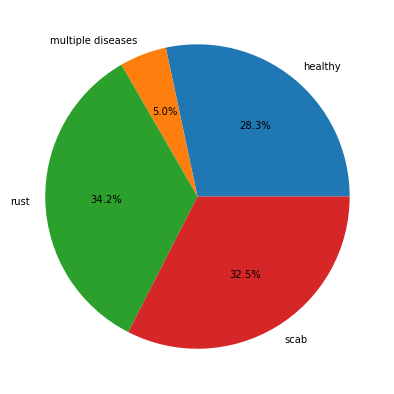

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(7,7))
label = ['healthy','multiple diseases','rust','scab']
healthy = train.loc[train['healthy']==1]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]
plt.pie([len(healthy),len(multiple_diseases),len(rust),len(scab)],labels=label,autopct='%.1f%%')
# plt.pie()

In [5]:
import matplotlib.gridspec as gridspec
import cv2

def show_images(img_ids,rows=2,cols=3):
    plt.figure(figsize=(15,8))
    grid = gridspec.GridSpec(rows,cols)
    
    for idx,img_id in enumerate(img_ids):
        img_path = f'{data_path}/images/{img_id}.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

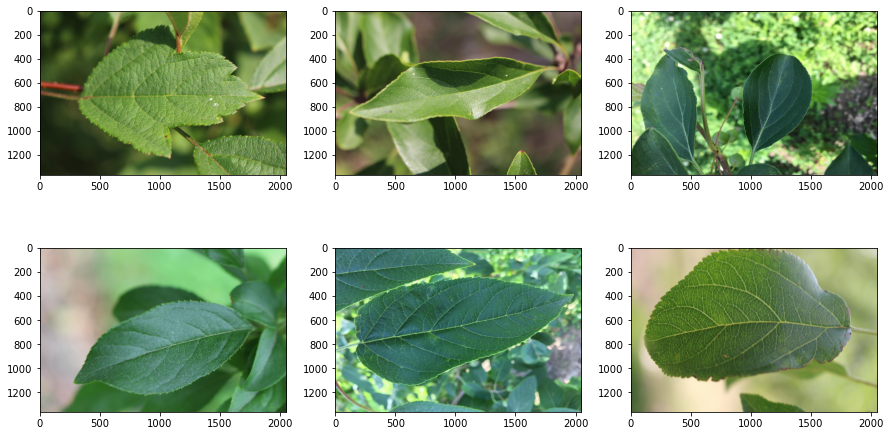

In [6]:
healty_img = healthy['image_id'][-6:]
show_images(healty_img)

In [7]:
import torch
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [8]:
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")


Using device: mps


In [9]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train,test_size=0.1,stratify=train[['healthy','multiple_diseases','rust','scab']])

In [10]:
import cv2
from torch.utils.data import Dataset
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, df, img_dir,transform=None,is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_id = self.df.iloc[idx,0]
        img_path = self.img_dir+img_id+'.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        if self.transform is not None :
            image = self.transform(image=image)['image']
            
        if self.is_test:
            return image
        else:
            label = np.argmax(self.df.iloc[idx,1:5])
            return image,label
    

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [12]:
transform_train = A.Compose([
    A.Resize(450,650),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2,p=0.3),
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1,scale_limit=0.2,rotate_limit=30,p=0.3),
    A.OneOf([A.Emboss(p=1),A.Sharpen(p=1),A.Blur(p=1)],p=0.3),
    A.PiecewiseAffine(p=0.3),
    A.Normalize(),
    ToTensorV2()    
])

transform_test = A.Compose([
    A.Resize(450,650),
    A.Normalize(),
    ToTensorV2()
])

In [13]:
img_dir = './plant-pathology-2020-fgvc7/images/'

dataset_train = ImageDataset(train,img_dir,transform=transform_train)
dataset_valid = ImageDataset(valid,img_dir,transform=transform_test)

In [14]:
g = torch.Generator()

from torch.utils.data import DataLoader

batch_size = 4
loader_train = DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
loader_valid = DataLoader(dataset_valid,batch_size=batch_size,shuffle=False)
# loader_valid = DataLoader(dataset_valid,batch_size=batch_size,shuffle=False,generator=g,num_workers=2)
#why ??

In [15]:
!pip install efficientnet-pytorch

In [16]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b7',num_classes=4)
model = model.to(device)

Loaded pretrained weights for efficientnet-b7


In [17]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.00006,weight_decay=0.0001)

In [27]:
from transformers import get_cosine_schedule_with_warmup
epochs =39
scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps = len(loader_train)*3,num_training_steps = len(loader_train)*epochs)


In [18]:
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

# epochs = 5
for epoch in range(epochs):
    model.train()
    epoch_train_loss=0
    for images,labels in tqdm(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        epoch_train_loss +=loss.item()
        optimizer.step()
        scheduler.step()
        
    print(f'epoch : {epoch+1/epochs}, loss : {epoch_train_loss/len(loader_train):.4f}')

    model.eval()
    epoch_valid_loss = 0
    preds_list =[]
    true_onehot_list = []
    
    with torch.no_grad():
        for images,labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss +=loss.item()
            
            preds = torch.softmax(outputs.cpu(),dim=1).numpy()
            true_onehot = torch.eye(4)[labels].cpu().numpy()
            
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
            
        print(f'epoch : {epoch+1/epochs}, loss : {epoch_valid_loss/len(loader_valid)}, ROC AUC : {roc_auc_score(true_onehot_list,preds_list):.4f}')
        

  0%|          | 0/410 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
dataset_test = ImageDataset(test,img_dir,transform=transform_test,is_test=True)
loader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=False)

dataset_TTA = ImageDataset(test,img_dir,transform=transform_train,is_test=True)
loader_TTA = DataLoader(dataset_TTA,batch_size =batch_size, shuffle=False)


In [30]:
model.eval()
preds_test = np.zeros((len(test),4))


In [33]:
with torch.no_grad():
    for i,images in enumerate(loader_test):
        images = images.to(device)
        outputs=model(images)
        preds_part = torch.softmax(outputs.cpu(),dim=1).squeeze().numpy()
        preds_test[i*batch_size:(i+1)*batch_size] += preds_part

submission_test = submission.copy()
submission_test[['healthy','multiple_diseases','rust','scab']] = preds_test


In [34]:
num_TTA = 7
preds_tta = np.zeros((len(test),4))

for i in range(num_TTA):
    with torch.no_grad():
        images=images.to(device)
        outputs = model(images)
        preds_part = torch.softmax(outputs.cpu(),dim=1).squeeze().numpy()
        preds_tta[i*batch_size:(i+1)*batch_size] +=preds_part
preds_tta /=num_TTA
submission_tta = submission.copy()
submission_tta[['healthy','multiple_diseases','rust','scab']] = preds_tta


In [35]:
submission_test.to_csv('submission_test.csv',index=False)
submission_tta.to_csv('submission_tta.csv',index=False)

In [36]:
# 레이블 스무딩
def apply_label_smmothing(df,target,alpha,threshold):
    df_target=df[target].copy()
    k=len(target)
    for idx,row in df_target.iterrows():
        if(row>threshold).any():
            row = (1-alpha)*row+alpha/k
            df_target.iloc[idx]=row
    return df_target


In [ ]:
alpha = 0.001
threshold = 0.999

submission_test_ls = submission_test.copy()
submission_tta_ls = submission_tta.copy()

target=['healthy','multiple_diseases','rust','scab']

submission_test_ls[target] = apply_label_smmothing(sumission_test_ls,target,alpha,threshold)
submission_tta_ls[target] = apply_label_smmothing(sumission_tta_ls,target,alpha,threshold)